In [2]:
import numpy as np
import pandas as pd
import random as python_random
import shutil
import os
import datetime
from PIL import Image
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# for reproducibility purposes
SEED = 123
tf.random.set_seed(SEED)
classes=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

# load tensorboard extension
%reload_ext tensorboard
# specify the log directory where the tensorboard logs will be written
%tensorboard --logdir logs

2022-04-10 20:56:23.055919: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-10 20:56:23.055938: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Found 1452 images belonging to 26 classes.
Found 363 images belonging to 26 classes.


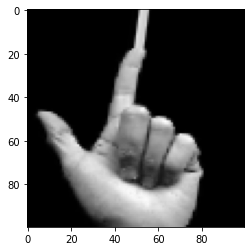

In [3]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20.0,
    width_shift_range=20.0,
    height_shift_range=20.0,
    shear_range=0.1,
    zoom_range=.2,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
    
)

train_generator = img_generator.flow_from_directory(
  './asl_dataset',
  target_size=(100,100),
  color_mode='grayscale',
  classes=classes,
  class_mode='categorical',
  seed=SEED,
  shuffle=False,
  subset='training'
)

val_generator = img_generator.flow_from_directory(
  './asl_dataset',
  target_size=(100,100),
  color_mode='grayscale',
  classes=classes,
  class_mode='categorical',
  seed=SEED,
  shuffle=False,
  subset='validation'
)

for i, image in enumerate(val_generator):
  if i == 5:
    plt.imshow(image[0][1], cmap = 'gray')
    break



In [4]:
def make_directories():
    d = datetime.datetime.today()
    timestamp = d.strftime('%Y%m%d_%H%M%S')
    # folder to store the tensorboard logs
    tensorlog_folder = os.path.join(os.path.curdir, 'logs', timestamp)
    # folder to store the trained models
    checkpoint_folder = os.path.join(os.path.curdir, 'models', timestamp)

    os.mkdir(tensorlog_folder)
    os.mkdir(checkpoint_folder)

    return checkpoint_folder, tensorlog_folder

In [5]:
check_dir, tboard_dir = make_directories()

input = keras.Input(shape=(100, 100, 1))
layer1 = tf.keras.layers.Conv2D(64, (6,6), activation= 'relu', name="layer1")
layer2 = tf.keras.layers.Conv2D(32, (6,6), activation= 'relu', name="layer2")
layer3 = tf.keras.layers.MaxPool2D((2,2), name="layer3")
layer4 = tf.keras.layers.Conv2D(64, (4,4), activation= 'relu', name="layer4")
layer5 = tf.keras.layers.Conv2D(64, (4,4), activation= 'relu', name="layer5")
layer6 = tf.keras.layers.Flatten(name="layer6")
layer7 = tf.keras.layers.Dense(128, activation='relu', name='layer7')
layer8 = tf.keras.layers.Dense(128, activation='relu', name='layer8')
# layer6 = tf.keras.layers.Dense(128, activation='relu', name='layer6')

output =  tf.keras.layers.Dense(len(classes), activation='softmax', name='symbol')

network = output(layer8(layer7(layer6(layer5(layer4(layer3(layer2(layer1(input)))))))))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model = tf.keras.Model(inputs=input, outputs=network, name="Logan")


model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              # loss_weights=[0.1],
              metrics=[tf.keras.metrics.top_k_categorical_accuracy, 'accuracy'],
              )


early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
checkpoints = keras.callbacks.ModelCheckpoint(
    filepath=check_dir,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)
tensorboard = keras.callbacks.TensorBoard(
    log_dir=tboard_dir
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-5,
    verbose=1
)

callbacks = [checkpoints, tensorboard, reduce_lr]

# fit the model with training and validation generators
# In addition please specify the following arguments
# steps_per_epoch=len(df_train)/batch_size
# validation_steps=len(df_val)/batch_size
# (5)
print(model.summary())
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False)
model.fit(
        train_generator,
        epochs=25,
        validation_data=val_generator,
        batch_size=8, 
        callbacks=callbacks,
        # steps_per_epoch=len(train)/batch_size,
        # validation_steps=len(val)/batch_size
        )




Model: "Logan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 layer1 (Conv2D)             (None, 95, 95, 64)        2368      
                                                                 
 layer2 (Conv2D)             (None, 90, 90, 32)        73760     
                                                                 
 layer3 (MaxPooling2D)       (None, 45, 45, 32)        0         
                                                                 
 layer4 (Conv2D)             (None, 42, 42, 64)        32832     
                                                                 
 layer5 (Conv2D)             (None, 39, 39, 64)        65600     
                                                                 
 layer6 (Flatten)            (None, 97344)             0     

2022-04-10 20:56:30.714609: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-10 20:56:30.714632: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-10 20:56:30.714649: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (logan-All-Series): /proc/driver/nvidia/version does not exist
2022-04-10 20:56:30.715872: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


None
Epoch 1/25
46/46 [==============================] - ETA: 0s - loss: 12.8548 - top_k_categorical_accuracy: 0.0944 - accuracy: 0.0055

2022-04-10 20:58:04.277150: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/20220410_205630/assets
46/46 [==============================] - 93s 2s/step - loss: 12.8548 - top_k_categorical_accuracy: 0.0944 - accuracy: 0.0055 - val_loss: 3.2427 - val_top_k_categorical_accuracy: 0.2204 - val_accuracy: 0.0248 - lr: 0.0010
Epoch 2/25
46/46 [==============================] - 89s 2s/step - loss: 3.2928 - top_k_categorical_accuracy: 0.1674 - accuracy: 0.0145 - val_loss: 3.2176 - val_top_k_categorical_accuracy: 0.2810 - val_accuracy: 0.0551 - lr: 0.0010
Epoch 3/25
46/46 [==============================] - 88s 2s/step - loss: 3.2435 - top_k_categorical_accuracy: 0.1887 - accuracy: 0.0324 - val_loss: 3.1672 - val_top_k_categorical_accuracy: 0.3196 - val_accuracy: 0.0689 - lr: 0.0010
Epoch 4/25
46/46 [==============================] - 91s 2s/step - loss: 3.6127 - top_k_categorical_accuracy: 0.2466 - accuracy: 0.0337 - val_loss: 3.1417 - val_top_k_categorical_accuracy: 0.3003 - val_accuracy: 0.0689 - lr: 0.0010
Epoch 5/25
46/46 [=